In [1]:
import findspark
findspark.init('/opt/spark/spark-3.2.1-bin-hadoop3.2')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## Import SparkSession
from pyspark.sql import SparkSession

## Create SparkSession 
spark = SparkSession.builder \
      .master("local") \
      .config("spark.mongodb.input.uri", "mongodb://127.0.0.1") \
      .config("spark.mongodb.output.uri", "mongodb://127.0.0.1") \
      .appName("Spark-MLlib-Titanic") \
      .getOrCreate() 

22/06/22 14:24:42 WARN Utils: Your hostname, ubuntu-machine resolves to a loopback address: 127.0.1.1; using 192.168.128.161 instead (on interface wlp0s20f3)
22/06/22 14:24:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/22 14:24:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/06/22 14:24:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
from pyspark.sql.types import StructField, IntegerType, StringType, StructType, FloatType
from pyspark.sql.functions import from_json, col

schema = StructType([ \
    StructField("PassengerId",IntegerType(),True), \
    StructField("Survived",IntegerType(),True), \
    StructField("Pclass",IntegerType(),True), \
    StructField("Name", StringType(), True), \
    StructField("Sex", StringType(), True), \
    StructField("Age", FloatType(), True), \
    StructField("SibSp", IntegerType(), True), \
    StructField("Parch", IntegerType(), True), \
    StructField("Ticket", StringType(), True), \
    StructField("Fare", FloatType(), True), \
    StructField("Cabin", StringType(), True), \
    StructField("Embarked", StringType(), True)
  ])

In [5]:
df = spark.read.csv('hdfs://localhost:9000/data/train.csv', header=True, schema=schema)
df.printSchema()
df.show(truncate=False)

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

+-----------+--------+------+-------------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|Name                                                   |Sex   |Age |SibSp|Parch|Ticket          |Fare   |Cabin|Embarked|
+-----------+--------+------+-------------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|1          |0       |3     |Braund, Mr. Owen Harris                                |male

In [6]:
df = df.toPandas()

id_dict = df.to_dict(orient='records')

In [7]:
from kafka import KafkaProducer

topic = 'Titanic'
bootstrap_servers = 'localhost:9092'
producer = KafkaProducer(bootstrap_servers=bootstrap_servers)

In [8]:
import json

for i in id_dict:
    i = json.dumps(i)
    future = producer.send(topic, bytes(i, encoding='utf-8'))
    print(f'Sending msg: {i}')

    result = future.get(timeout=60)

Sending msg: {"PassengerId": 1, "Survived": 0, "Pclass": 3, "Name": "Braund, Mr. Owen Harris", "Sex": "male", "Age": 22.0, "SibSp": 1, "Parch": 0, "Ticket": "A/5 21171", "Fare": 7.25, "Cabin": null, "Embarked": "S"}
Sending msg: {"PassengerId": 2, "Survived": 1, "Pclass": 1, "Name": "Cumings, Mrs. John Bradley (Florence Briggs Thayer)", "Sex": "female", "Age": 38.0, "SibSp": 1, "Parch": 0, "Ticket": "PC 17599", "Fare": 71.2833023071289, "Cabin": "C85", "Embarked": "C"}
Sending msg: {"PassengerId": 3, "Survived": 1, "Pclass": 3, "Name": "Heikkinen, Miss. Laina", "Sex": "female", "Age": 26.0, "SibSp": 0, "Parch": 0, "Ticket": "STON/O2. 3101282", "Fare": 7.925000190734863, "Cabin": null, "Embarked": "S"}
Sending msg: {"PassengerId": 4, "Survived": 1, "Pclass": 1, "Name": "Futrelle, Mrs. Jacques Heath (Lily May Peel)", "Sex": "female", "Age": 35.0, "SibSp": 1, "Parch": 0, "Ticket": "113803", "Fare": 53.099998474121094, "Cabin": "C123", "Embarked": "S"}
Sending msg: {"PassengerId": 5, "Surv

In [9]:
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "Titanic") \
    .option("startingOffsets", "earliest") \
    .load()
    
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [10]:
from pyspark.sql.types import StructField, IntegerType, StringType, StructType, FloatType
from pyspark.sql.functions import from_json, col

schema = StructType() \
    .add("PassengerId",IntegerType()) \
    .add("Survived",IntegerType()) \
    .add("Pclass",IntegerType()) \
    .add("Name", StringType()) \
    .add("Sex", StringType()) \
    .add("Age", FloatType()) \
    .add("SibSp", IntegerType()) \
    .add("Parch", IntegerType()) \
    .add("Ticket", StringType()) \
    .add("Fare", FloatType()) \
    .add("Cabin", StringType()) \
    .add("Embarked", StringType())

In [11]:
df = df.selectExpr("CAST(value AS STRING)")

In [12]:
df = df.select(from_json(col('value'),schema).alias('data')).select('data.*')

In [13]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [14]:
## Fill Nan values (Age)

from pyspark.sql.functions import when

# With toPandas()

# pd_df = df.toPandas()
# pd_df['Age'] = pd_df.groupby('Sex')['Age'].apply(lambda x: x.fillna(x.mean()))

# df = spark.createDataFrame(pd_df)
# df.select('Age').show()

# With pyspark

male_mean = df.filter((df['Age'] != 'NaN') & (df['Sex'] == 'male')).agg({'Age':'mean'}).collect()[0][0]
female_mean = df.filter((df['Age'] != 'NaN') & (df['Sex'] == 'female')).agg({'Age':'mean'}).collect()[0][0]

df = df.withColumn("Age",  when((df.Age == "NaN") & (df.Sex == "male"), male_mean).otherwise(df.Age))
df = df.withColumn("Age",  when((df.Age == "NaN") & (df.Sex == "female"), female_mean).otherwise(df.Age))

In [15]:
## Surname

from pyspark.sql.functions import udf, col

_udf = udf(lambda x: x.split(',')[0])
df = df.withColumn('Surname', _udf(col('Name')))

In [16]:
## Title

_udf = udf(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
df = df.withColumn('Title', _udf(col('Name')))

In [17]:
## Gender-Rate

male_rate = df.groupBy(['Sex']).agg({'Survived':'mean'}).collect()[0][1]
female_rate = df.groupBy(['Sex']).agg({'Survived':'mean'}).collect()[1][1]

_udf = udf(lambda x: male_rate if x == 'male' else female_rate)
df = df.withColumn('Gender-Rate', _udf(col('Sex')))

In [18]:
## Fill NaN values (Embarked)

df = df.na.fill('S', subset=['Embarked'])

In [19]:
## Embarked-Rate

df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()

male_C_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[0][2]
male_S_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[1][2]
male_Q_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[2][2]
female_C_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[3][2]
female_S_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[4][2]
female_Q_rate = df.groupBy(['Sex','Embarked']).agg({'Survived':'mean'}).collect()[5][2]

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def func(Sex, Embarked):

    # if Sex == 'male' and Embarked == 'C':
    #     return male_C_rate
    # if Sex == 'male' and Embarked == 'S':
    #     return male_S_rate
    # if Sex == 'male' and Embarked == 'Q':
    #     return male_Q_rate

    # if Sex == 'female' and Embarked == 'C':
    #     return female_C_rate
    # if Sex == 'female' and Embarked == 'S':
    #     return female_S_rate
    # if Sex == 'female' and Embarked == 'Q':
    #     return female_Q_rate

    sex = ['male','male','male','female','female','female']
    embarked = ['C','S','Q','C','S','Q']
    embarked_rate = [male_C_rate,male_S_rate,male_Q_rate,female_C_rate,female_S_rate,female_Q_rate]

    for i in range(6):
        if Sex == sex[i] and Embarked == embarked[i]:
            return embarked_rate[i]
            
    return 0
func_udf = udf(func, FloatType())
df = df.withColumn('Embarked-Rate',func_udf(df['Sex'], df['Embarked']))

In [20]:
## Pclass-Rate

df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()

male_3_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[0][2]
female_3_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[1][2]
female_1_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[2][2]
female_2_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[3][2]
male_2_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[4][2]
male_1_rate = df.groupBy(['Sex','Pclass']).agg({'Survived':'mean'}).collect()[5][2]

from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf

def func(Sex, Pclass):

    sex = ['male','female','female','female','male','male']
    pclass = [3,3,1,2,2,1]
    pclass_rate = [male_3_rate,female_3_rate,female_1_rate,female_2_rate,male_2_rate,male_1_rate]

    for i in range(6):
        if Sex == sex[i] and Pclass == pclass[i]:
            return pclass_rate[i]
            
    return 0
func_udf = udf(func, FloatType())
df = df.withColumn('Pclass-Rate',func_udf(df['Sex'], df['Pclass']))

In [21]:
## FamilySize

def func(is_Family):
    if is_Family != 0:
        return 1
    else:
        return 0    

df = df.withColumn('is_Family', df['Parch'] + df['SibSp'])

func_udf = udf(func, IntegerType())
df = df.withColumn('is_Family', func_udf(df['is_Family']))

df = df.drop('Parch','SibSp')

In [22]:
df = df.drop('PassengerId', 'Name', 'Ticket','Cabin', 'Surname')

In [23]:
## Categorical Sex

from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol="Sex", outputCol="sexIndex")

df = gender_indexer.fit(df).transform(df)
df = df.drop('Sex')

In [24]:
## Categorical Embarked

from pyspark.ml.feature import StringIndexer

embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="embarkedIndex")

df = embarked_indexer.fit(df).transform(df)
df = df.drop('Embarked','Fare')

In [25]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn('Title', regexp_replace('Title', 'theCountess', 'Mrs'))
df = df.withColumn('Title', regexp_replace('Title', 'Don', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Col', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Rev', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Mme', 'Mrs'))
df = df.withColumn('Title', regexp_replace('Title', 'Capt', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Dr', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Sir', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Jonkheer', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Mlle', 'Mrs'))
df = df.withColumn('Title', regexp_replace('Title', 'Major', 'Mr'))
df = df.withColumn('Title', regexp_replace('Title', 'Ms', 'Mrs'))

In [26]:
## Categorical Title

from pyspark.ml.feature import StringIndexer

title_indexer = StringIndexer(inputCol="Title", outputCol="titleIndex")

df = title_indexer.fit(df).transform(df)
df = df.drop('Title')

22/06/22 14:25:00 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:01 WARN KafkaDataConsumer: KafkaDataConsumer is not running in Un

In [27]:
df = df.withColumn('Gender-Rate',col('Gender-Rate').cast('int').alias('Gender-Rate'))

In [28]:
train, test = df.randomSplit([0.8,0.2])

In [29]:
feature = train.columns
feature.remove('Survived')
feature

['Pclass',
 'Age',
 'Gender-Rate',
 'Embarked-Rate',
 'Pclass-Rate',
 'is_Family',
 'sexIndex',
 'embarkedIndex',
 'titleIndex']

In [30]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [31]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Survived', featuresCol='features')

rf = rf.fit(train)

22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:02 WARN KafkaDataConsumer: KafkaDataConsumer is not running in Un

In [32]:
pred = rf.transform(test)

In [33]:
pred.select('Survived', 'prediction', 'probability').show(5)

22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894
22/06/22 14:25:06 WARN KafkaDataConsumer: KafkaDataConsumer is not running in Un

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.61411591080724...|
|       0|       0.0|[0.64353161641370...|
|       0|       0.0|[0.64353161641370...|
|       0|       0.0|[0.68160671501639...|
|       0|       0.0|[0.70031388498747...|
+--------+----------+--------------------+
only showing top 5 rows



In [ ]:
pred_pd = pred.select(['Survived', 'prediction', 'probability']).toPandas()
pred_pd

In [35]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_Survived'] = pred_pd['Survived'].map(lambda x: np.eye(2)[int(x)])

In [36]:
# pred_pd[(pred_pd['prediction'] == 0) & (pred_pd['Survived'] == 0)] ## 0 ==> 0
# pred_pd[(pred_pd['prediction'] == 0) & (pred_pd['Survived'] == 1)] ## 0 ==> 1

# pred_pd[(pred_pd['prediction'] == 1) & (pred_pd['Survived'] == 1)] ## 1 ==> 1
# pred_pd[(pred_pd['prediction'] == 1) & (pred_pd['Survived'] == 0)] ## 1 ==> 0

pred_pd.pivot_table(index='prediction', columns='Survived', aggfunc={'prediction':'count'})

prediction    
Survived            0   1
prediction               
0.0               216  48
1.0                 9  94

In [37]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_Survived'].tolist())

from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 0.902


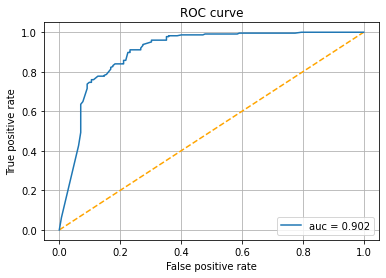

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [49]:
spark.createDataFrame(pred_pd[['Survived','prediction']]) \
.write.format("mongo").mode("overwrite")\
    .option("database","company")\
    .option("collection", "Titanic").save()